In [1]:
import os
import numpy as np
import cv2
import pandas as pd
import math
from sklearn.preprocessing import LabelEncoder
from skimage import feature as skif
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [2]:
# BRINT_s描述子
# B:
def loadDataProcessing(file):
    with open(file) as f:
        s = f.read().splitlines()  # 读取逐行数据放入list列表中
    allMessage = []
    for i in range(len(s)):
        # print(s[9])#打印第九行
        temp = s[i]
        temp = temp.split(' ')  # 按空格划分字符串为list列表
        while '' in temp:  # 删除list中的空元素
            temp.remove('')
        # print(temp)

        # 对单行进行赋值处理
        if len(temp) > 10:
            id = temp[0]
            sex = temp[2][:-1]
            age = temp[4][:-1]
            race = temp[6][:-1]
            face = temp[8][:-1]
            prop = temp[10:]
            prop[0] = prop[0][2:]

            prop.pop(-1)
            # 判断prop是否为空，并且根据prop特征的个数来用空格进行拼接
            if len(prop) != 0:
                str = ''
                for i in range(len(prop) - 1):
                    str = str + prop[i] + ' '
                str = str + prop[len(prop) - 1]
                prop = str
            else:
                prop = 'NaN'

            # print(prop)
            temp = [id, sex, age, race, face, prop]
            allMessage.append(temp)
        # print(temp)
        else:
            pass
    return allMessage


In [3]:
def roadLabels(path):
    # 将字符串标签“male”，“female”处理为1，0
    if (type(path).__name__ == 'list'):  # 用于处理列表数据
        labels = []
        for i in range(len(y)):
            labels.append(y[i][1])
    else:  # 用于处理csv文件
        df = pd.read_csv(path)
        labels = df.iloc[:, 1].values.tolist()

    # 给标签编码
    le = LabelEncoder()
    labels = le.fit_transform(labels)
    # print(labels)
    return labels


def roadData(path):
    # 读取文件夹下的文件，返回一个list列表
    path = path  # 文件夹目录
    files = os.listdir(path)  # 得到文件夹下的所有文件名称
    s = []
    for file in files:  # 遍历文件夹
        with open(path + '/' + file, 'rb') as f:
            x = np.fromfile(f, dtype=np.uint8)

            if len(x) == 128 * 128:
                x = x.reshape(128, 128)

            s.append(x)

    return s

In [4]:
def get_lbp_data(img, lbp_radius, lbp_point):

    lbpImg = img.copy()
    # 使用LBP方法提取图像的纹理特征.
    lbp = skif.local_binary_pattern(lbpImg, lbp_point, lbp_radius, 'default')

    return lbp


def get_pixel_else_0(l, idx, idy):
    if idx < int(len(l)) - 1 and idy < len(l[0]):
        return l[idx, idy]
    else:
        return 0


def bilinearInterpolation(x, y, img):
    x1, y1 = int(x), int(y)
    x2, y2 = math.ceil(x), math.ceil(y)

    r1 = (x2 - x) / (x2 - x1) * get_pixel_else_0(img, x1, y1) + (x - x1) / (x2 - x1) * get_pixel_else_0(img, x2, y1)
    r2 = (x2 - x) / (x2 - x1) * get_pixel_else_0(img, x1, y2) + (x - x1) / (x2 - x1) * get_pixel_else_0(img, x2, y2)

    return (y2 - y) / (y2 - y1) * r1 + (y - y1) / (y2 - y1) * r2


def thresholded(center, pixels):
    out = []
    if len(pixels) > 0:
        out = np.where((pixels - center) >= 0, 1, 0)
    return out

In [5]:
def getNeighboringPixelsPaperVersion(img, R, P, x, y):
    pixels = []

    indexes = np.array(list(range(0, P)), dtype=np.float64)
    dy = -R * np.sin(2 * np.pi * indexes / P)
    dx = R * np.cos(2 * np.pi * indexes / P)

    dy = np.where(abs(dy) < 5.0e-10, 0, dy)
    dx = np.where(abs(dx) < 5.0e-10, 0, dx)

    for point in range(0, P):
        r = y + dy[point]
        c = x + dx[point]

        fr = math.floor(r)
        fc = math.floor(c)

        cr = math.ceil(r)
        cc = math.ceil(c)

        rr = np.round(r)
        rc = np.round(c)

        if abs(c - rc) < 10e-7 and abs(r - rr) < 10e-7:
            pixels.append(get_pixel_else_0(img, int(r), int(c)))
        else:
            tr = r - fr
            tc = c - fc

            w1 = (1 - tc) * (1 - tr)
            w2 = tc * (1 - tr)
            w3 = (1 - tc) * tr
            w4 = tc * tr

            value = w1 * get_pixel_else_0(img, fr, fc) + w2 * get_pixel_else_0(img, fr, cc) + \
                    w3 * get_pixel_else_0(img, cr, fc) + w4 * get_pixel_else_0(img, cr, cc)

            pixels.append(value)

    return pixels


def getNeighboringPixels(img, R, P, x, y):
    pixels = []

    indexes = np.array(list(range(0, P)), dtype=np.float64)
    dy = -R * np.sin(2 * np.pi * indexes / P)
    dx = R * np.cos(2 * np.pi * indexes / P)

    dy = np.where(abs(dy) < 5.0e-10, 0, dy)
    dx = np.where(abs(dx) < 5.0e-10, 0, dx)

    for point in range(0, P):
        c = x + dx[point]
        r = y + dy[point]

        if r < 0 or c < 0:
            pixels.append(0)
            continue
        if int(r) == r:
            if int(c) != c:
                c1 = int(c)
                c2 = math.ceil(c)
                w1 = (c2 - c) / (c2 - c1)
                w2 = (c - c1) / (c2 - c1)

                pixels.append(int((w1 * get_pixel_else_0(img, int(r), int(c)) + \
                                   w2 * get_pixel_else_0(img, int(r), math.ceil(c))) / (w1 + w2)))
            else:
                pixels.append(get_pixel_else_0(img, int(r), int(c)))
        elif int(c) == c:
            r1 = int(r)
            r2 = math.ceil(r)
            w1 = (r2 - r) / (r2 - r1)
            w2 = (r - r1) / (r2 - r1)
            pixels.append((w1 * get_pixel_else_0(img, int(r), int(c)) + \
                           w2 * get_pixel_else_0(img, math.ceil(r), int(c))) / (w1 + w2))
        else:
            pixels.append(bilinearInterpolation(r, c, img))

    return pixels
def genMappingTable(P):
    mapTable = np.zeros(2 ** P)
    numElms = P + 2
    for i in range(0, 2 ** P):
        msb = 128 & i
        lsb = 1 & i
        count = format(i, '#010b').count('01') + format(i, '#010b').count('10') + ((msb >> (P - 1)) ^ lsb)

        if count <= 2:
            mapTable[i] = bin(i).count('1')
        else:
            mapTable[i] = P + 1

    return mapTable

In [6]:
def LBP(img, R, P):
    lbpImg = img.copy()

    for x in range(0, len(img)):
        for y in range(0, len(img[0])):
            center = img[x, y]
            pixels = getNeighboringPixels(img, R, P, x, y)
            values = thresholded(center, pixels)

            res = 0
            for a in range(0, len(values)):
                res += values[a] * (2 ** a)
            lbpImg.itemset((x, y), res)

    return lbpImg


def ULBP(img, R, P):
    uLbpImg = img.copy()
    p = np.array(list(range(1, P)))

    for x in range(0, len(img)):
        for y in range(0, len(img[0])):
            center = img[x, y]
            pixels = getNeighboringPixels(img, R, P, x, y)
            values = np.array(thresholded(center, pixels))
            res = abs(values[P - 1] - values[0])
            res += np.sum(abs(values[p] - values[p - 1]))
            uLbpImg.itemset((x, y), res)

    return uLbpImg


def LBPriu2(img, R, P):
    uLbpImg = ULBP(img, R, P)

    lbpRiu2Img = img.copy()

    for x in range(0, len(img)):
        for y in range(0, len(img[0])):
            if uLbpImg[x, y] <= 2:
                center = img[x, y]
                pixels = getNeighboringPixels(img, R, P, x, y)
                values = np.array(thresholded(center, pixels))
                lbpRiu2Img.itemset((x, y), np.sum(values))
            else:
                lbpRiu2Img.itemset((x, y), P + 1)
    return lbpRiu2Img

In [7]:
def calcCLBPMThreshold(img, P, R):
    threshold = 0
    total = 0

    for x in range(0, len(img)):
        for y in range(0, len(img[0])):
            center = img[x, y]
            pixels = getNeighboringPixels(img, R, P, x, y)
            sp, mp = LDSMT(center, pixels)
            total += np.mean(mp)

    return total / (len(img) * len(img[0]))


def calcLocalDifferences(img, P, R):
    ld = np.zeros((img.shape[0], img.shape[1], P), dtype=np.float64)

    for y in range(0, len(img)):
        for x in range(0, len(img[0])):
            center = img[y, x]
            # pixels = getNeighboringPixels(img,R,P,x,y)
            pixels = getNeighboringPixelsPaperVersion(img, R, P, x, y)
            ld[y, x, 0:P] = pixels - center

    return ld

In [8]:
def calcTransitions(pattern, P):
    u_value = np.absolute(pattern[:, :, P - 1] - pattern[:, :, 0])
    u_value += np.sum(np.absolute(pattern[:, :, 1:P] - pattern[:, :, 0:P - 1]), 2)
    return u_value


def LDSMT(ld):
    sp = np.where(ld >= 0, 1, -1)
    mp = np.absolute(ld)
    return sp, mp


def CLBP_S(sp, P):
    sp = np.where(sp >= 0, 1, 0)
    pp2 = 2 ** (np.array(list(range(0, P))))
    return np.dot(sp, pp2)


def CLBP_M(mp, P):
    c = np.mean(mp)
    tp = np.where(mp >= c, 1, 0)
    pp2 = (np.array(list(range(0, P))))
    return np.dot(tp, pp2)


def CLBP_C(im):
    c = np.mean(im)
    return np.where(im >= c, 1, 0)


def CLBP_S_riu2(sp, P):
    sp = np.where(sp >= 0, 1, 0)
    # sp_total = np.sum(sp,2)
    # u_value = calcTransitions(sp,P)
    # return np.where(u_value <= 2, sp_total, P+1)
    pp2 = 2 ** (np.array(list(range(0, P))))
    indexes = np.dot(sp, pp2)
    return indexes


def CLBP_M_riu2(mp, P):
    c = np.mean(mp)
    tp = np.where(mp >= c, 1, 0)
    # pp2 = np.array([1]*P)
    # tp_total = np.dot(tp,pp2.T)
    # u_value = calcTransitions(tp,P)
    # return np.where(u_value <= 2, tp_total, P+1)
    pp2 = 2 ** (np.array(list(range(0, P))))
    indexes = np.dot(tp, pp2)
    return indexes

In [9]:
def brint_s(srcimg, radius, neighbours):

    src = srcimg
    n_images = srcimg.shape[0]
    hist = np.zeros((n_images, 256))
    q = int(neighbours / 8)
    neighbourhoodCoords = getNeighbourhoodCoordinates(radius, neighbours)

    height = src.shape[0] - 2 * radius  # rows
    width = src.shape[1] - 2 * radius  # cols
    # print(height, width)

    dst = np.zeros((height, width), dtype=np.uint8)
    for y in range(radius, height + radius):
        for x in range(radius, width + radius):
            # 获得邻域
            neighbourhood = src[int(x - radius):int(x + radius + 1), int(y - radius):int(y + radius + 1)]
            # print(neighbourhood)
            nData = neighbourhood.data
            # 邻域像素值
            neighbourVector = np.zeros(neighbours, dtype=float)

            for p in range(0, neighbours):
                xy = neighbourhoodCoords[p]

                p1 = neighbourhood[int(xy[1]), int(xy[0])]
                p2 = neighbourhood[int(xy[1]), int(xy[2])]
                p3 = neighbourhood[int(xy[3]), int(xy[0])]
                p4 = neighbourhood[int(xy[3]), int(xy[2])]
                neighbourVector[p] = xy[4] * p1 + xy[5] * p2 + xy[6] * p3 + xy[7] * p4

            bnt_s = 0
            for i in range(0, 8):
                m = 0
                for k in range(0, q):
                    m += neighbourVector[q * i + k]
                m /= q
                if m - nData[radius, radius] >= 0:
                    s = 1
                else:
                    s = 0
                bnt_s += s * (2 ** i)

            dst[y - radius, x - radius] = float(minROR(bnt_s, q))

    tmp1 = np.zeros((height, width), dtype=np.uint8)
    cv2.transpose(dst, tmp1)
    return tmp1

In [10]:
def getNeighbourhoodCoordinates(radius, neighbours):
    neighbourhoodCoords = np.zeros((neighbours, 8), dtype=float)
    for i in range(0, neighbours):
        # neighbourhoodCoord = np.zeros(8,dtype=float)
        x = float(radius * math.cos(i * 2 * math.pi / neighbours) + radius)
        y = float(radius * math.sin(i * 2 * math.pi / neighbours + radius))

        neighbourhoodCoords[i, 0] = math.floor(x)
        neighbourhoodCoords[i, 1] = math.floor(y)
        neighbourhoodCoords[i, 2] = math.ceil(x)
        neighbourhoodCoords[i, 3] = math.ceil(y)

        tx = float(x - math.floor(x))
        ty = float(y - math.floor(y))

        neighbourhoodCoords[i, 4] = (1 - tx) * (1 - ty)
        neighbourhoodCoords[i, 5] = tx * (1 - ty)
        neighbourhoodCoords[i, 6] = (1 - tx) * ty
        neighbourhoodCoords[i, 7] = tx * ty

    return neighbourhoodCoords

def minROR(x, numShifts):
    m = x
    for i in range(1, numShifts):
        m = min(m, (x >> i) | (x << (8 - i)))

    return m

lbp特征： [ 172  391  506 1592 4132 2307  595  436 5795  458]
brint_s特征： [ 786  559  434 1245 3017 1185  379 4950 1043 1778]
clbp_s特征： [ 172  521  505 1581 4123 1921  590 1421 4264 1286]
clbp_m特征： [9458  938 1048 1163  158   85   93  507  128 2806]
clbp_m/c特征： [array([[6146., 3312.],
       [ 171.,  767.],
       [ 218.,  830.],
       [ 539.,  624.],
       [  53.,  105.],
       [  30.,   55.],
       [  37.,   56.],
       [ 278.,  229.],
       [  50.,   78.],
       [ 917., 1889.]])]
clbp_s_m/c特征： [array([ 172.,  521.,  505., 1581., 4123., 1921.,  590., 1421., 4264.,
       1286., 6146., 3312.,  171.,  767.,  218.,  830.,  539.,  624.,
         53.,  105.,   30.,   55.,   37.,   56.,  278.,  229.,   50.,
         78.,  917., 1889.])]
clbp_s/m特征： [array([[7.100e+01, 1.700e+01, 1.700e+01, 1.600e+01, 2.000e+00, 9.000e+00,
        3.000e+00, 4.000e+00, 3.000e+00, 3.000e+01],
       [2.070e+02, 3.600e+01, 4.200e+01, 3.700e+01, 8.000e+00, 1.100e+01,
        1.200e+01, 1.310e+02, 2.000e+00,

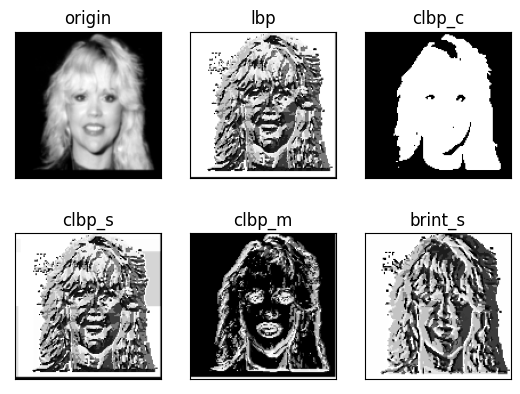

In [11]:
if __name__ == '__main__':
    # 原始数据处理——————————————————————————————————————————————————————————————
    # 将性别与图片相匹配
    # A:
    # x, y = match_PicGen("./rawdata", 'faceDR', 'faceDS')  # 读取文件夹下的文件

    # B:
    x = roadData("./rawdata")  # 读取文件夹下的文件
    # 使用原始数据标签
    y1 = loadDataProcessing('faceDR')
    y2 = loadDataProcessing('faceDS')
    y = y1 + y2
    # 只留性别标签
    y = roadLabels(y)
    # 剔除超过128*128的数据和标签
    x.pop(1190)
    x.pop(1186)
    y = np.delete(y, 1190)
    y = np.delete(y, 1186)


    # gendata即为性别数据集，共3991列，每行第0位元素为性别标签，第1位是对应像素矩阵
    gendata = []
    for i in range(len(y)):
        for j in range(len(x)):
            if i == j:
                t = (y[i], x[j],)
                gendata.append(t)
    # print(gendata)

    # 展示其中一张图片
    # cv2.imshow("orgin", gendata[37][1])
    # cv2.waitKey(0)

    # 其中一张图片特征对比
    # img = cv2.imread(pathFile.rstrip(), cv2.IMREAD_GRAYSCALE)
    # img = cv2.imread("F:/jupyter_files/IMG_20190726_221059.jpg")
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = gendata[3906][1]

    img = img / 255
    img = (img - np.mean(img)) / np.std(img) * 20 + 128

    radius = 1
    numPoints = 8

    dp = calcLocalDifferences(img, numPoints, radius)
    sp, mp = LDSMT(dp)


    lbp_1 = []
    clbp_s = []
    clbp_m = []
    clbp_mc = []
    clbp_s_mc = []
    clbp_sm = []
    clbp_smc = []
    brint = []


    mappingTable = genMappingTable(numPoints)

    # 其中一张图片提取展示
    # # LBP
    # # lbp_riu2 = LBPriu2(img, radius, numPoints)
    # # lbp_riu2 = lbp_riu2.astype('int64')
    # # mapped_lbp = mappingTable[lbp_riu2]
    # # (hist_lbp, bins) = np.histogram(mapped_lbp, bins=numPoints + 2)
    # # lbp_1.append(hist_lbp)
    lbp1 = get_lbp_data(img, radius, numPoints)
    lbp1 = lbp1.astype('int64')
    mapped_lbp = mappingTable[lbp1]
    (hist_lbp, bins) = np.histogram(mapped_lbp, bins=numPoints + 2)
    lbp_1.append(hist_lbp)
    print('lbp特征：', hist_lbp)

    # BRINT_S
    brint1 = brint_s(img, 2, 32)
    mapped_brint1 = mappingTable[brint1]
    (hist_brint, bins) = np.histogram(mapped_brint1, bins=numPoints + 2)
    brint.append(hist_brint)
    print('brint_s特征：', hist_brint)

    # CLBP_C
    clbp_c = CLBP_C(img)
    # mapped_clbp_c = mappingTable[clbp_c]
    # (hist_c, bins) = np.histogram(mapped_clbp_c, bins=numPoints + 2)
    # clbp_c.append(hist_c)

    # CLBP_S_riu2
    clbp_s_riu2 = CLBP_S_riu2(sp, numPoints)
    mapped_clbp_s_riu2 = mappingTable[clbp_s_riu2]
    (hist_s, bins) = np.histogram(mapped_clbp_s_riu2, bins=numPoints + 2)
    clbp_s.append(hist_s)
    print('clbp_s特征：', hist_s)
    #
    # CLBP_M_riu2
    clbp_m_riu2 = CLBP_M_riu2(mp, numPoints)
    mapped_clbp_m_riu2 = mappingTable[clbp_m_riu2]
    (hist_m, bins) = np.histogram(mapped_clbp_m_riu2, bins=numPoints + 2)
    clbp_m.append(hist_m)
    print('clbp_m特征：', hist_m)

    # CLBP_M/C
    hist_mc, xedges, yedges = np.histogram2d(mapped_clbp_m_riu2.flatten(), clbp_c.flatten(), bins=[numPoints + 2, 2])
    clbp_mc.append(hist_mc)
    print('clbp_m/c特征：', clbp_mc)

    # CLBP_S_M/C
    hist_s_mc = np.concatenate((hist_s.flatten(), hist_mc.flatten()), axis=0)
    clbp_s_mc.append(hist_s_mc)
    print('clbp_s_m/c特征：', clbp_s_mc)

    # CLBP_S/M
    hist_sm, xedges, yedges = np.histogram2d(mapped_clbp_s_riu2.flatten(), mapped_clbp_m_riu2.flatten(), bins=[numPoints + 2, numPoints + 2])
    clbp_sm.append(hist_sm)
    print('clbp_s/m特征：', clbp_sm)

    # CLBP_S/M/C
    clbp_mc_sum = np.where(clbp_c > 0, clbp_m_riu2 + numPoints + 2, clbp_m_riu2)
    hist_smc, xedges, yedges = np.histogram2d(mapped_clbp_s_riu2.flatten(), clbp_mc_sum.flatten(), bins=[numPoints + 2, 2 * (numPoints + 2)])
    clbp_smc.append(hist_smc)
    print('clbp_s/m/c特征：', clbp_smc)


    # title命名
    titles = ['origin', 'lbp', 'clbp_c', 'clbp_s', 'clbp_m', 'brint_s']

    images = [img, lbp1, clbp_c, clbp_s_riu2, clbp_m_riu2, brint1]
    for i in range(6):
        plt.subplot(2, 3, i + 1), plt.imshow(images[i], 'gray')
        if i + 1 <= 6:
            plt.title(titles[i])
        # plt.title(titles[i])
        plt.xticks([]), plt.yticks([])
    plt.show()